In [1]:
# 구글 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Seoul/data

/content/drive/MyDrive/Seoul/data


### 라이브러리 로드

In [3]:
import os
import json
import folium
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import geopandas as gpd #지도

import xml.etree.ElementTree as ET
from bs4 import BeautifulSoup

In [4]:
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf

In [5]:
# 한글폰트 설정
plt.rc('font', family='NanumBarunGothic')

In [6]:
# 동 데이터
dong = pd.read_csv('0.거주인구특성.csv', encoding='cp949')
dong.head()

,시군구명,행정동명,전체세대,1인세대,기초생활수급자,외국인,행정구역코드,행정동코드,총인구수,노령층인구,노령층비율,장애인인구,장애인비율,차상위인구,차상위비율,cluster,1인세대비율,기초생활수급자비율,외국인비율
0,종로구,청운효자동,5129.0,1952.0,162.0,229.0,1101072,11110515,12024,2915,0.001272,228.0,0.000577,1,0.000006,1,0.000999,0.000560,0.000534
1,종로구,사직동,4570.0,2317.0,112.0,404.0,1101053,11110530,9371,2472,0.001079,432.0,0.001094,74,0.000480,1,0.001185,0.000387,0.000942
2,종로구,삼청동,1148.0,563.0,38.0,87.0,1101054,11110540,2498,834,0.000364,542.0,0.001373,65,0.000422,1,0.000288,0.000131,0.000203
3,종로구,부암동,4144.0,1642.0,135.0,379.0,1101055,11110550,9703,2535,0.001106,587.0,0.001487,182,0.001181,1,0.000840,0.000467,0.000883
4,종로구,평창동,7270.0,2321.0,107.0,430.0,1101056,11110560,18204,4877,0.002128,505.0,0.001279,172,0.001116,1,0.001188,0.000370,0.001002


In [7]:
dong_cluster = dong.merge(gu[['시군구명','cluster']], on='시군구명', how='left')
dong_cluster['cluster'].value_counts()

NameError: ignored

In [ ]:
# cluster1이 주거 취약 지역으로 선정
print('시군구:',dong_cluster.loc[dong_cluster['cluster']==1,'시군구명'].nunique())
print('행정동:',dong_cluster.loc[dong_cluster['cluster']==1,'행정동명'].nunique())

In [ ]:
# 지도 시각화 geo.json 파일로드 및 서울시만 추출
with open('geo.json', 'r') as f:
  data = json.load(f)

feat, d_code = [], {}
for d in data['features']:
  # print((d['properties']['code']))
  # break
  c, n = d['properties']['code'], d['properties']['name']
  if c < '2000000':
    feat.append(d)
    if n in d_code:
      print(n, c, d_code[n])
    else:
      d_code[n] = c

data['features'] = feat

In [ ]:
# 지도 시각화 geo.json 파일로드 및 서울시만 추출
with open('geo.json', 'r') as f:
  df = json.load(f)

for d in df['features']:
  # print((d['properties']['code']))
  # break
  c, n = d['properties']['code'], d['properties']['name']
  if '강일' in n and c < '2000000':
    print(n, c)

In [ ]:
dong_cluster['행정동명'] = dong_cluster['행정동명'].apply(lambda x: x.replace('.', '·'))
dong_cluster['행정구역코드'] = [d_code[n] for n in dong_cluster['행정동명']]

In [ ]:
dong_cluster[dong_cluster['행정동명']=='신사동']

In [ ]:
# 신사동만 2개니까 이거 처리해주면 됨 - 신사동 1123051 1121068
dong_cluster.loc[(dong_cluster['시군구명']=='관악구')&(dong_cluster['행정동명']=='신사동'), '행정구역코드'] = '1121068'
dong_cluster.loc[(dong_cluster['시군구명']=='강남구')&(dong_cluster['행정동명']=='신사동'), '행정구역코드'] = '1123051'

In [ ]:
# dong_cluster.to_csv('0.거주인구특성.csv', encoding='cp949', index=False)

In [ ]:
dong_cluster['cluster'].value_counts()

In [ ]:
# 지도시각화 함수 - 컬럼, 색상
def plot_map(colname, color):
  m1 = folium.Map(location=[37.5502, 126.982], tiles='cartodbpositron', zoom_start=10)

  m1.choropleth(
      geo_data = data,
      name = '행정동별' + colname,
      data = dong_cluster,
      columns = ['행정구역코드', colname],
      key_on='properties.code',
      fill_color=color,
      highlight=True,
      fill_opacity=0.7,
      line_opacity=0.5,
      legend_name=colname
  )

  style_function = lambda x: {'fillColor': '#ffffff',
                              'color':'#000000',
                              'fillOpacity': 0.1,
                              'weight': 0.1}

  SuburbName = folium.features.GeoJson(
      data,
      style_function=style_function,
      control=False,
      tooltip=folium.features.GeoJsonTooltip(
          fields=['name',
                  'code'],
          aliases=['행정동명: ',
                  '행정구역코드: '],
          style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;")
      )
  )
  m1.add_child(SuburbName)
  m1.keep_in_front(SuburbName)
  folium.LayerControl().add_to(m1)

  return m1

In [ ]:
dong_cluster.info()

In [ ]:
plot_map('cluster', 'Set3')

In [ ]:
plot_map('노령층비율', 'YlOrRd')

In [ ]:
plot_map('노령층비율', 'Purples')

In [ ]:
plot_map('차상위비율', 'Oranges')

In [ ]:
# 차상위 비율 top10 확인하기
dong_cluster[['시군구명','행정동명','총인구수','차상위인구','차상위비율']].sort_values(by='차상위비율', ascending=False).head(10)

In [ ]:
c1 = dong_cluster[dong_cluster['cluster'] == 1][['행정구역코드','']]
print(c1.shape)
c1.head()

In [ ]:
# c1['행정동명'] = c1['시군구명'] + ' ' + c1['행정동명']
c1 = c1[['행정구역코드', '행정동명', '노령층비율','장애인비율','차상위비율']]
c1.head()

In [ ]:
# 스케일링 적용?
scaler = MinMaxScaler()

# 스케일 적용 열
scale_col = c1.columns[2:]

c1_scale = c1.copy()
scaler.fit(dong_cluster[scale_col])
c1_scale[scale_col] = scaler.transform(c1_scale[scale_col])
c1_scale.head()

In [ ]:
# 지도시각화 함수 - 컬럼, 색상
def plot_map(colname, color):
  m1 = folium.Map(location=[37.5502, 126.982], tiles='cartodbpositron', zoom_start=10)

  m1.choropleth(
      geo_data = data,
      name = '행정동별' + colname,
      data = c1_scale,
      columns = ['행정구역코드', colname],
      key_on='properties.code',
      fill_color=color,
      highlight=True,
      fill_opacity=0.7,
      line_opacity=0.5,
      legend_name=colname
  )

  style_function = lambda x: {'fillColor': '#ffffff',
                              'color':'#000000',
                              'fillOpacity': 0.1,
                              'weight': 0.1}

  SuburbName = folium.features.GeoJson(
      data,
      style_function=style_function,
      control=False,
      tooltip=folium.features.GeoJsonTooltip(
          fields=['name',
                  'code'],
          aliases=['행정동명: ',
                  '행정구역코드: '],
          style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;")
      )
  )
  m1.add_child(SuburbName)
  m1.keep_in_front(SuburbName)
  folium.LayerControl().add_to(m1)

  return m1

In [ ]:
plot_map('노령층비율', 'YlOrRd')

In [ ]:
plot_map('장애인비율', 'YlOrRd')

In [ ]:
plot_map('차상위비율', 'YlOrRd')

In [ ]:
c1_scale['거주인구특성'] = (c1_scale['노령층비율'] + c1_scale['장애인비율'] + c1_scale['차상위비율'])/3*100

In [ ]:
c1_scale.sort_values(by='거주인구특성', ascending=False).head(15)

#### 동별 거주인구 특성 추가

In [ ]:
## 기존 동별 거주인구특성
dong.head()

In [ ]:
## 외국인수
fore = pd.read_csv('외국인.csv', sep='\t', encoding='cp949')
display(fore.head())
fore.info()

In [ ]:
fore[fore['행정동명'].isin(['둔촌1동', '대림1동'])]

In [ ]:
int(fore['외국인'].mean())

In [ ]:
fore['외국인'] = fore['외국인'].astype(int)
fore.loc[fore['외국인'] == 0, '외국인'] = int(fore['외국인'].mean())
fore[['외국인']].info()

In [ ]:
## 기초생활수급자
income = pd.read_csv('기초생활수급자.csv', sep='\t', encoding='cp949')
income.columns = ['시군구명','행정동명','기초생활수급자']
income['기초생활수급자'] = income['기초생활수급자'].astype(int)
income.head()

In [ ]:
## 세대수
home = pd.read_csv('세대수.csv', sep='\t', encoding='cp949')
home['전체세대'] = home['전체세대'].astype(int)
home['1인세대'] = home['1인세대'].astype(int)
print(home.shape)
home.head()

In [ ]:
env2 = home.merge(income, on=['시군구명','행정동명'])
env2 = env2.merge(fore, on=['시군구명','행정동명'])
env2['행정동명'] = env2['행정동명'].apply(lambda x: x.replace('.', '·'))
env2 = env2.merge(dong, on=['시군구명','행정동명'], how='right')

env2.info()

In [ ]:
env2[env2['1인세대'].isna()]

In [ ]:
env2['전체세대'].fillna(int(env2['전체세대'].mean()),inplace=True)
env2['1인세대'].fillna(int(env2['1인세대'].mean()),inplace=True)
env2['기초생활수급자'].fillna(int(env2['기초생활수급자'].mean()),inplace=True)
env2['외국인'].fillna(int(env2['외국인'].mean()),inplace=True)

env2.info()

In [ ]:
env2['1인세대비율'] = env2['1인세대'] / sum(env2['1인세대'])
env2['기초생활수급자비율'] = env2['기초생활수급자'] / sum(env2['기초생활수급자'])
env2['외국인비율'] = env2['외국인'] / sum(env2['외국인'])
env2['노령층비율'] = env2['노령층인구'] / sum(env2['노령층인구'])
env2['장애인비율'] = env2['장애인인구'] / sum(env2['장애인인구'])
env2['차상위비율'] = env2['차상위인구'] / sum(env2['차상위인구'])

env2.describe()

In [ ]:
env_p = env2[['시군구명', '행정동명','1인세대비율','기초생활수급자비율','외국인비율','노령층비율','장애인비율','차상위비율']]
env_p = pd.merge(dong[['행정구역코드','행정동코드','시군구명','행정동명']], env_p, on=['시군구명','행정동명'])
env_p.info()

In [ ]:
env2.to_csv('0.거주인구특성.csv', encoding='cp949', index=False)
env_p.to_csv('0.거주인구특성비율.csv', encoding='cp949', index=False)

In [ ]:
## 스케일링
from sklearn.preprocessing import StandardScaler
env_scaler = MinMaxScaler()
env_c = ['1인세대비율','기초생활수급자비율','외국인비율','노령층비율','장애인비율','차상위비율']

env_scale = env_p.copy()
env_scale[env_c] = env_scaler.fit_transform(env_scale[env_c])
env_scale[env_c].describe()

In [ ]:
# 지도시각화 함수 - 컬럼, 색상
def plot_map(colname, color):
  m1 = folium.Map(location=[37.5502, 126.982], tiles='cartodbpositron', zoom_start=10)

  m1.choropleth(
      geo_data = data,
      name = '행정동별' + colname,
      data = env_scale,
      columns = ['행정구역코드', colname],
      key_on='properties.code',
      fill_color=color,
      highlight=True,
      fill_opacity=0.7,
      line_opacity=0.5,
      legend_name=colname
  )

  style_function = lambda x: {'fillColor': '#ffffff',
                              'color':'#000000',
                              'fillOpacity': 0.1,
                              'weight': 0.1}

  SuburbName = folium.features.GeoJson(
      data,
      style_function=style_function,
      control=False,
      tooltip=folium.features.GeoJsonTooltip(
          fields=['name',
                  'code'],
          aliases=['행정동명: ',
                  '행정구역코드: '],
          style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;")
      )
  )
  m1.add_child(SuburbName)
  m1.keep_in_front(SuburbName)
  folium.LayerControl().add_to(m1)

  return m1

In [ ]:
plot_map('외국인비율', 'YlOrRd')

### 클러스터링

#### 구 클러스터링

In [8]:
# 구 데이터
gu = pd.read_csv('0.gu_cluster.csv', encoding='cp949')
gu.rename(columns={'cluster':'complete_linkage'}, inplace=True)
gu.head()

,시군구명,단위면적당 교통 접근성,노후비율,1인당 복지시설 수,단위면적당 녹지면적,빈집 비율,희망의집 수리 비율,complete_linkage
0,강남구,15.113924,0.281025,0.000196,0.050825,0.066512,0.000431,0
1,강동구,16.958113,0.167270,0.000279,0.024634,0.034944,0.002906,0
2,강북구,17.838983,0.289182,0.000390,0.005875,0.024699,0.007921,1
3,강서구,15.585042,0.098263,0.000323,0.027810,0.040459,0.001706,0
4,관악구,16.875211,0.208941,0.000266,0.008541,0.011920,0.005232,1


In [9]:
## 레이터차트 그리기
# cat = [*gu_columns, gu_columns[0]]
# cluster0 = [*list(gu_c.loc[0]), list(gu_c.loc[0])[0]]
# cluster1 = [*list(gu_c.loc[1]), list(gu_c.loc[1])[0]]
# cluster2 = [*list(gu_c.loc[2]), list(gu_c.loc[2])[0]]

# label_loc = np.linspace(start=0, stop=2*np.pi, num=len(cluster0))

# plt.figure(figsize=(8,8))
# ax = plt.subplot(polar=True)
# plt.xticks(label_loc, labels=cat, fontsize=13)
# ax.plot(label_loc, cluster0, label='Cluster 0', color='lightcoral')
# ax.fill(label_loc, cluster0, color='lightcoral', alpha=0.3)
# ax.plot(label_loc, cluster1, label='Cluster 1', color='lightgreen')
# ax.fill(label_loc, cluster1, color='lightgreen', alpha=0.3)
# ax.plot(label_loc, cluster2, label='Cluster 2', color='skyblue')
# ax.fill(label_loc, cluster2, color='skyblue', alpha=0.3)

# ax.legend(loc='upper left')
# plt.show()

In [10]:
# 군집 변수
gu_columns = ['단위면적당 교통 접근성',	'노후비율',	'1인당 복지시설 수',	'단위면적당 녹지면적',	'빈집 비율',	'희망의집 수리 비율']

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


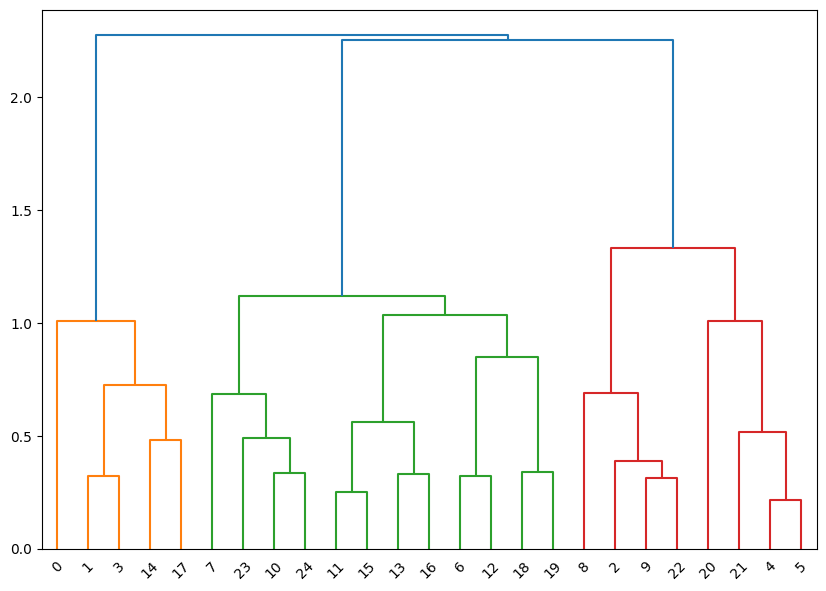

In [11]:
# 필요한 라이브러리를 불러오기.
from sklearn.preprocessing import *
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

# 데이터프레임을 생성하기.
df = gu[gu_columns]

# 데이터를 표준화합니다.
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df)

# 계층적 군집화를 수행합니다.
cluster = AgglomerativeClustering(affinity='euclidean', linkage='ward')
cluster_result = cluster.fit_predict(df_scaled)

gu['ward_linkage'] = cluster_result

# 덴드로그램을 그립니다.
linked = linkage(df_scaled, 'ward')
plt.figure(figsize=(10, 7))
dendrogram(linked, labels=df.index.tolist())
plt.show()

In [14]:
gu['complete_linkage'].value_counts()

0    9
1    8
2    8
Name: complete_linkage, dtype: int64

In [15]:
gu['ward_linkage'].value_counts()

0    20
1     5
Name: ward_linkage, dtype: int64

In [16]:
# K-means Clustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import math

kmeans = KMeans(n_clusters=3, random_state=0)
kmeans_result = kmeans.fit_predict(df_scaled)
gu['kmeans'] = kmeans_result
gu['kmeans'].value_counts()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


1    11
2     9
0     5
Name: kmeans, dtype: int64

In [19]:
# !pip install scikit-learn-extra

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 5.0 MB/s eta 0:00:00


In [20]:
# K-medois Clustering
from sklearn_extra.cluster import KMedoids

KMedoids = KMedoids(n_clusters=3, random_state=0)
Kmedoids_result = KMedoids.fit_predict(df_scaled)
gu['kmedoids'] = Kmedoids_result
gu['kmedoids'].value_counts()

0    12
2     9
1     4
Name: kmedoids, dtype: int64

In [21]:
gu.head()

,시군구명,단위면적당 교통 접근성,노후비율,1인당 복지시설 수,단위면적당 녹지면적,빈집 비율,희망의집 수리 비율,complete_linkage,ward_linkage,kmeans,kmedoids
0,강남구,15.113924,0.281025,0.000196,0.050825,0.066512,0.000431,0,1,0,2
1,강동구,16.958113,0.167270,0.000279,0.024634,0.034944,0.002906,0,1,0,2
2,강북구,17.838983,0.289182,0.000390,0.005875,0.024699,0.007921,1,0,2,1
3,강서구,15.585042,0.098263,0.000323,0.027810,0.040459,0.001706,0,1,0,2
4,관악구,16.875211,0.208941,0.000266,0.008541,0.011920,0.005232,1,0,2,2


In [22]:
gu_scaler = MinMaxScaler()
gu_cluster = gu.copy()
gu_cluster[gu_columns] = gu_scaler.fit_transform(gu_cluster[gu_columns])

In [23]:
for c in ('complete_linkage', 'ward_linkage', 'kmeans', 'kmedoids'):
  d = gu_cluster.groupby(c, as_index=False)[gu_columns].mean()
  display(d)
  print('')

,complete_linkage,단위면적당 교통 접근성,노후비율,1인당 복지시설 수,단위면적당 녹지면적,빈집 비율,희망의집 수리 비율
0,0,0.322393,0.336478,0.266354,0.591190,0.501636,0.211817
1,1,0.197017,0.522155,0.538169,0.153481,0.370079,0.772905
2,2,0.797138,0.256071,0.505517,0.362099,0.208582,0.542127


,ward_linkage,단위면적당 교통 접근성,노후비율,1인당 복지시설 수,단위면적당 녹지면적,빈집 비율,희망의집 수리 비율
0,0,0.521003,0.39541,0.476382,0.322873,0.307142,0.591989
1,1,0.086945,0.26918,0.243805,0.597577,0.600233,0.117368


,kmeans,단위면적당 교통 접근성,노후비율,1인당 복지시설 수,단위면적당 녹지면적,빈집 비율,희망의집 수리 비율
0,0,0.086945,0.269180,0.243805,0.597577,0.600233,0.117368
1,1,0.770049,0.281460,0.430503,0.431804,0.257642,0.480777
2,2,0.216613,0.534682,0.532457,0.189736,0.367642,0.727914


,kmedoids,단위면적당 교통 접근성,노후비율,1인당 복지시설 수,단위면적당 녹지면적,빈집 비율,희망의집 수리 비율
0,0,0.726181,0.284458,0.422681,0.416148,0.237361,0.483170
1,1,0.185720,0.701739,0.768370,0.128748,0.419749,0.923213
2,2,0.155303,0.337072,0.289002,0.437398,0.512965,0.326191


In [24]:
def scoring(c):
  df = gu_cluster.groupby(c, as_index=False)[gu_columns].mean()
  score = []
  for i, col in df.iterrows():
    s = 0
    for c in gu_columns:
      if c in ['단위면적당 교통 접근성', '1인당 복지시설 수', '단위면적당 녹지면적']:
        s += (1- col[c])
      else:
        s += col[c]
    score.append(round(s/6 * 100,2))

  return score

In [25]:
for c in ('complete_linkage', 'ward_linkage', 'kmeans', 'kmedoids'):
  print(c)
  d = scoring(c)
  d = pd.DataFrame(data = {'score':d})
  display(d)
  print('')

complete_linkage


,score
0,47.83
1,62.94
2,39.03



ward_linkage


,score
0,49.57
1,50.97



kmeans


,score
0,50.97
1,39.79
2,61.52



kmedoids


,score
0,40.67
1,66.03
2,54.91


In [26]:
## complete -> cluster 1
## ward -> cluster 0
## kmeans -> cluster 2
## kmedois -> cluster 1

gu['Complete Linkage'] = [1 if c==1 else 0 for c in gu['complete_linkage']]
gu['Ward Linkage'] = [1 if c==0 else 0 for c in gu['ward_linkage']]
gu['K-Means Clustering'] = [1 if c==2 else 0 for c in gu['kmeans']]
gu['K-Medoids Clustering'] = [1 if c==1 else 0 for c in gu['kmedoids']]

In [27]:
gu['주거취약지역'] = gu['Complete Linkage'] + gu['Ward Linkage'] + gu['K-Means Clustering'] + gu['K-Medoids Clustering']
gu.head()

,시군구명,단위면적당 교통 접근성,노후비율,1인당 복지시설 수,단위면적당 녹지면적,빈집 비율,희망의집 수리 비율,complete_linkage,ward_linkage,kmeans,kmedoids,Complete Linkage,Ward Linkage,K-Means Clustering,K-Medoids Clustering,주거취약지역
0,강남구,15.113924,0.281025,0.000196,0.050825,0.066512,0.000431,0,1,0,2,0,0,0,0,0
1,강동구,16.958113,0.167270,0.000279,0.024634,0.034944,0.002906,0,1,0,2,0,0,0,0,0
2,강북구,17.838983,0.289182,0.000390,0.005875,0.024699,0.007921,1,0,2,1,1,1,1,1,4
3,강서구,15.585042,0.098263,0.000323,0.027810,0.040459,0.001706,0,1,0,2,0,0,0,0,0
4,관악구,16.875211,0.208941,0.000266,0.008541,0.011920,0.005232,1,0,2,2,1,1,1,0,3


In [32]:
gu_cluster.head()

,시군구명,단위면적당 교통 접근성,노후비율,1인당 복지시설 수,단위면적당 녹지면적,빈집 비율,희망의집 수리 비율,complete_linkage,ward_linkage,kmeans,kmedoids
0,강남구,0.057102,0.491810,0.106495,1.000000,1.000000,0.000000,0,1,0,2
1,강동구,0.184252,0.185696,0.398285,0.417327,0.426531,0.309861,0,1,0,2
2,강북구,0.244985,0.513762,0.788633,0.000000,0.240424,0.937941,1,0,2,1
3,강서구,0.089584,0.000000,0.552369,0.487986,0.526718,0.159645,0,1,0,2
4,관악구,0.178537,0.297834,0.351729,0.059304,0.008285,0.601159,1,0,2,2


In [33]:
gu_cluster.to_csv('gu_cluster.csv', index=False, encoding='cp949')

In [28]:
# 지도 시각화 geo.json 파일로드 및 서울시만 추출
with open('geo_sigungu.json', 'r') as f:
  data_gu = json.load(f)

feat = []
for d in data_gu['features']:
  # print((d['properties']['code']))
  # break
  c, n = d['properties']['code'], d['properties']['name']
  if c < '20000':
    feat.append(d)

data_gu['features'] = feat

In [41]:
for i, f in enumerate(data_gu['features']):
  try:
    env_r = gu[gu['시군구명'] == f['properties']['name']]

    data_gu['features'][i]['properties']['단위면적 당 교통 접근성'] = str(env_r['단위면적 당 교통 접근성'].values[0])
    data_gu['features'][i]['properties']['노후비율'] = str(env_r['노후비율'].values[0])
    data_gu['features'][i]['properties']['1인당 복지시설 수'] = str(env_r['1인당 복지시설 수'].values[0])
    data_gu['features'][i]['properties']['단위면적당 녹지면적'] = str(int(env_r['단위면적당 녹지면적'].values[0]))
    data_gu['features'][i]['properties']['빈집 비율'] = str(int(env_r['빈집 비율'].values[0]))
    data_gu['features'][i]['properties']['희망의집 수리 비율'] = str(int(env_r['희망의집 수리 비율'].values[0]))
  except:
    data_gu['features'][i]['properties']['대중교통'] = None
    data_gu['features'][i]['properties']['건물수'] = None
    data_gu['features'][i]['properties']['노후비율'] = None
    data_gu['features'][i]['properties']['복지시설'] = None
    data_gu['features'][i]['properties']['생활인구'] = None

In [47]:
# 지도시각화 함수 - 컬럼, 지도데이터, 색상
def plot_gu(data, df, colname, color, tooltip=True):
  m1 = folium.Map(location=[37.5502, 126.982], tiles='cartodbpositron', zoom_start=11)

  m1.choropleth(
      geo_data=data,
      name = colname,
      data = df,
      columns = ['시군구명', colname],
      key_on='properties.name',
      fill_color=color,
      highlight=True,
      fill_opacity=0.7,
      line_opacity=0.5,
      legend_name=colname
  )

  style_function = lambda x: {'fillColor': '#ffffff',
                              'color':'#000000',
                              'fillOpacity': 0.1,
                              'weight': 0.1}

  highlight_function = lambda x: {'fillColor': '#000000',
                                  'color':'#000000',
                                  'fillOpacity': 0.50,
                                  'weight': 0.1}
  if tooltip:
    SuburbName = folium.features.GeoJson(
        data,
        style_function=style_function,
        control=False,
        highlight_function=highlight_function,
        tooltip=folium.features.GeoJsonTooltip(
            fields=['name', 'code', colname],
            aliases=['시군구명','행정구역코드', colname],
            style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;"),
            sticky=True
            )
        )
  else:
    SuburbName = folium.features.GeoJson(
        data,
        style_function=style_function,
        control=False,
        highlight_function=highlight_function,
        tooltip=folium.features.GeoJsonTooltip(
            fields=['name', 'code'],
            aliases=['시군구명','행정구역코드'],
            style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;"),
            sticky=True
            )
      )
  m1.add_child(SuburbName)
  m1.keep_in_front(SuburbName)
  folium.LayerControl().add_to(m1)

  return m1

In [89]:
def cluster_result(cluster_t):
  print(cluster_t)
  print(*gu.loc[gu[cluster_t]==max(gu[cluster_t]), '시군구명'])
  return plot_gu(data_gu, gu, cluster_t, 'YlGn', False)

In [90]:
## Complete Linkage
cluster_result('Complete Linkage')

Complete Linkage
강북구 관악구 광진구 노원구 도봉구 용산구 은평구 종로구


/usr/local/lib/python3.10/dist-packages/folium/folium.py:465: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  warnings.warn(


In [91]:
## Ward Linkage
cluster_result('Ward Linkage')

Ward Linkage
강북구 관악구 광진구 노원구 도봉구 용산구 은평구 종로구


/usr/local/lib/python3.10/dist-packages/folium/folium.py:465: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  warnings.warn(


In [92]:
## K-Means Clustering
cluster_result('K-Means Clustering')

K-Means Clustering
강북구 관악구 광진구 노원구 도봉구 양천구 용산구 은평구 종로구


/usr/local/lib/python3.10/dist-packages/folium/folium.py:465: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  warnings.warn(


In [93]:
## K-Medoids Clustering
cluster_result('K-Medoids Clustering')

K-Medoids Clustering
강북구 노원구 도봉구 종로구


/usr/local/lib/python3.10/dist-packages/folium/folium.py:465: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  warnings.warn(


In [94]:
## 주거취약지역
cluster_result('주거취약지역')

주거취약지역
강북구 노원구 도봉구 종로구


/usr/local/lib/python3.10/dist-packages/folium/folium.py:465: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  warnings.warn(


In [107]:
select_gu = gu.loc[gu['주거취약지역']==4, '시군구명']
print(*select_gu)

강북구 노원구 도봉구 종로구


#### 동 클러스터링

In [96]:
# 동 데이터
dong = pd.read_csv('0.거주인구특성비율.csv', encoding='cp949')
dong.head()

,행정구역코드,행정동코드,시군구명,행정동명,1인세대비율,기초생활수급자비율,외국인비율,노령층비율,장애인비율,차상위비율
0,1101072,11110515,종로구,청운효자동,0.000999,0.000560,0.000534,0.001272,0.000577,0.000006
1,1101053,11110530,종로구,사직동,0.001185,0.000387,0.000942,0.001079,0.001094,0.000480
2,1101054,11110540,종로구,삼청동,0.000288,0.000131,0.000203,0.000364,0.001373,0.000422
3,1101055,11110550,종로구,부암동,0.000840,0.000467,0.000883,0.001106,0.001487,0.001181
4,1101056,11110560,종로구,평창동,0.001188,0.000370,0.001002,0.002128,0.001279,0.001116


In [379]:
# 동 클러스터 변수
dong_columns = ['기초생활수급자비율', '노령층비율', '장애인비율', '차상위비율']
dong_columns

['기초생활수급자비율', '노령층비율', '장애인비율', '차상위비율']

In [392]:
# 스케일링
dong_df = dong.loc[dong['시군구명'].isin(select_gu) ,dong_columns]

scaler = MinMaxScaler()
dong_scaled = scaler.fit_transform(dong_df)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


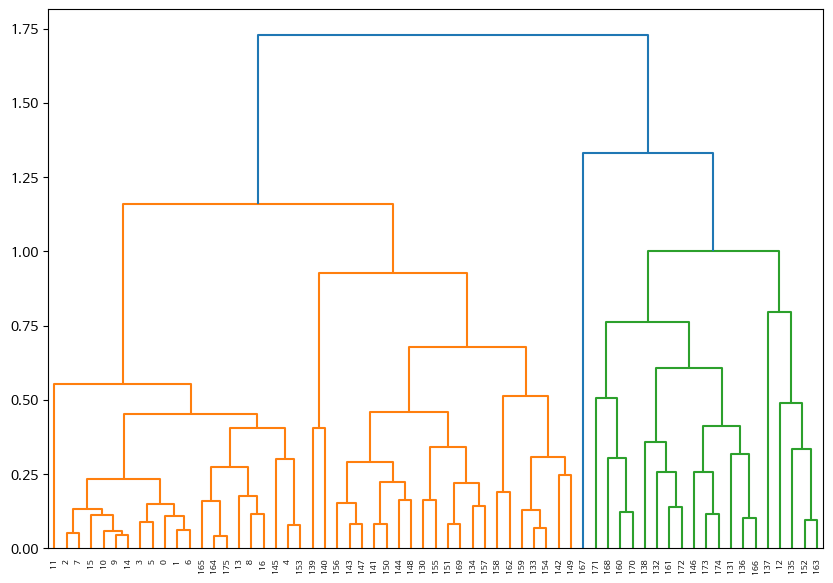

In [393]:
# 계층적 군집화를 수행합니다.
cluster = AgglomerativeClustering(affinity='euclidean', linkage='complete')
cluster_result = cluster.fit_predict(dong_scaled)

dong_scaled = pd.DataFrame(dong_scaled, columns = dong_df.columns, index=dong_df.index)
dong_scaled['cluster'] = cluster_result
dong_df['complete_linkage'] = cluster_result

# 덴드로그램을 그립니다.
linked = linkage(dong_scaled, 'complete')
plt.figure(figsize=(10, 7))
dendrogram(linked, labels=dong_scaled.index.tolist())
plt.show()

dong_scaled.drop(['cluster'], axis=1, inplace=True)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


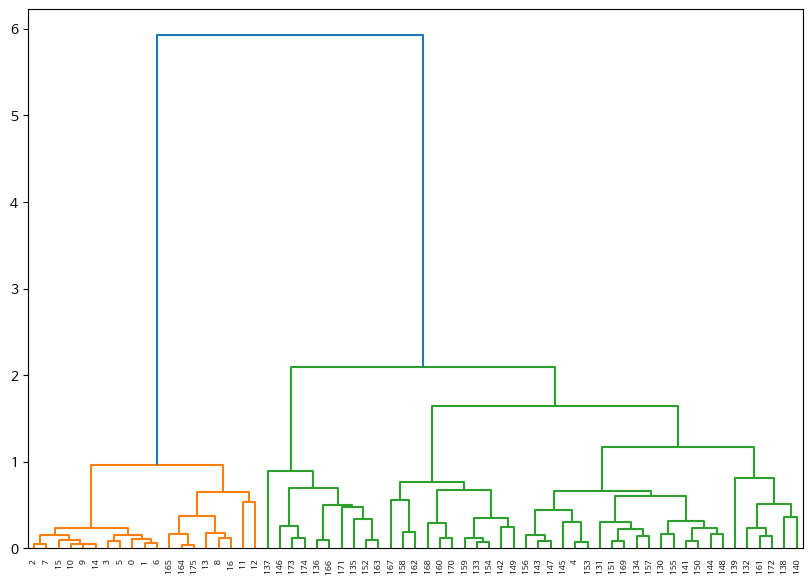

In [394]:
# 계층적 군집화를 수행합니다.
cluster = AgglomerativeClustering(affinity='euclidean', linkage='ward')
cluster_result = cluster.fit_predict(dong_scaled)

dong_scaled = pd.DataFrame(dong_scaled, columns = dong_scaled.columns, index=dong_scaled.index)
dong_scaled['cluster'] = cluster_result
dong_df['ward_linkage'] = cluster_result

# 덴드로그램을 그립니다.
linked = linkage(dong_scaled, 'ward')
plt.figure(figsize=(10, 7))
dendrogram(linked, labels=dong_scaled.index.tolist())
plt.show()

dong_scaled.drop(['cluster'], axis=1, inplace=True)

In [395]:
dong_df['complete_linkage'].value_counts()

1    43
0    20
Name: complete_linkage, dtype: int64

In [396]:
dong_df['ward_linkage'].value_counts()

0    44
1    19
Name: ward_linkage, dtype: int64

In [385]:
### 여러개의 클러스터링 갯수를 List로 입력 받아 각각의 실루엣 계수를 면적으로 시각화한 함수 작성
def visualize_silhouette(cluster_lists, X_features):

    from sklearn.datasets import make_blobs
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_samples, silhouette_score

    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    import math

    # 입력값으로 클러스터링 갯수들을 리스트로 받아서, 각 갯수별로 클러스터링을 적용하고 실루엣 개수를 구함
    n_cols = len(cluster_lists)

    # plt.subplots()으로 리스트에 기재된 클러스터링 수만큼의 sub figures를 가지는 axs 생성
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)

    # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 실루엣 개수 시각화
    for ind, n_cluster in enumerate(cluster_lists):

        # KMeans 클러스터링 수행하고, 실루엣 스코어와 개별 데이터의 실루엣 값 계산.
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(X_features)

        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)

        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n' \
                          'Silhouette Score :' + str(round(sil_avg,3)) )
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])

        # 클러스터링 갯수별로 fill_betweenx( )형태의 막대 그래프 표현.
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()

            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10

        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

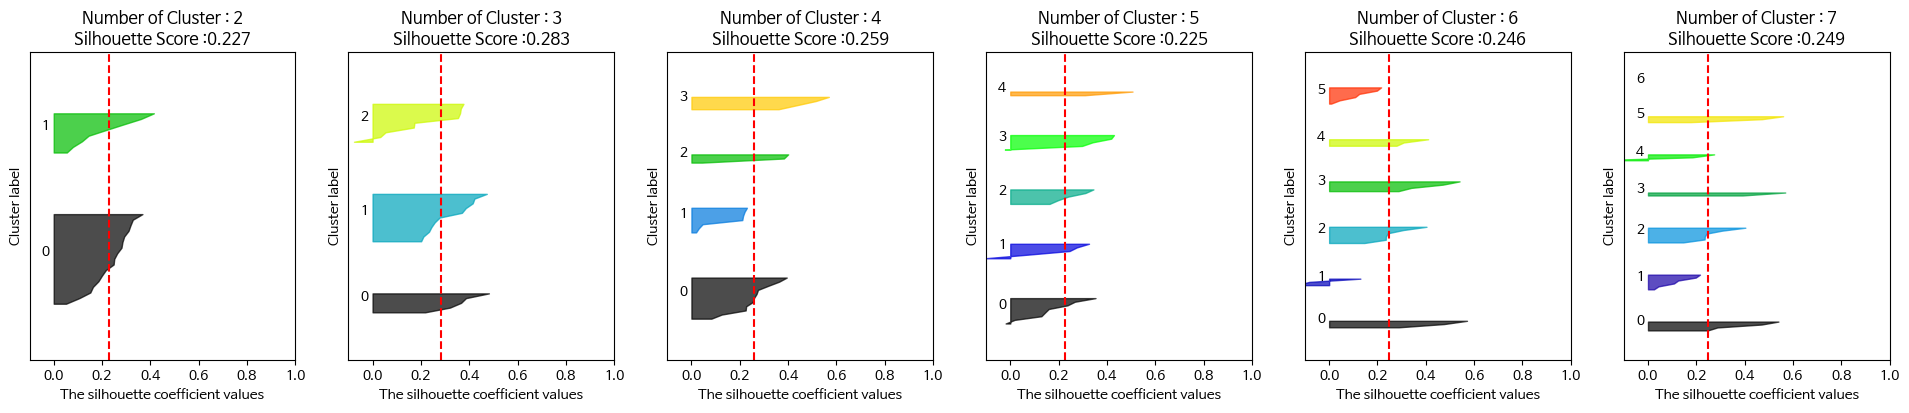

In [386]:
visualize_silhouette(range(2,8), df_scaled)

In [397]:
# K-means Clustering

kmeans = KMeans(n_clusters=3, random_state=0)
kmeans_result = kmeans.fit_predict(dong_scaled)
dong_df['kmeans'] = kmeans_result
dong_df['kmeans'].value_counts()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


1    30
0    21
2    12
Name: kmeans, dtype: int64

In [388]:
### 여러개의 클러스터링 갯수를 List로 입력 받아 각각의 실루엣 계수를 면적으로 시각화한 함수 작성
from sklearn_extra.cluster import KMedoids

def visualize_silhouette2(cluster_lists, X_features):

    from sklearn.datasets import make_blobs
    from sklearn_extra.cluster import KMedoids
    from sklearn.metrics import silhouette_samples, silhouette_score

    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    import math

    # 입력값으로 클러스터링 갯수들을 리스트로 받아서, 각 갯수별로 클러스터링을 적용하고 실루엣 개수를 구함
    n_cols = len(cluster_lists)

    # plt.subplots()으로 리스트에 기재된 클러스터링 수만큼의 sub figures를 가지는 axs 생성
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)

    # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 실루엣 개수 시각화
    for ind, n_cluster in enumerate(cluster_lists):

        # KMeans 클러스터링 수행하고, 실루엣 스코어와 개별 데이터의 실루엣 값 계산.
        clusterer = KMedoids(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(X_features)

        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)

        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n' \
                          'Silhouette Score :' + str(round(sil_avg,3)) )
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])

        # 클러스터링 갯수별로 fill_betweenx( )형태의 막대 그래프 표현.
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()

            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10

        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")

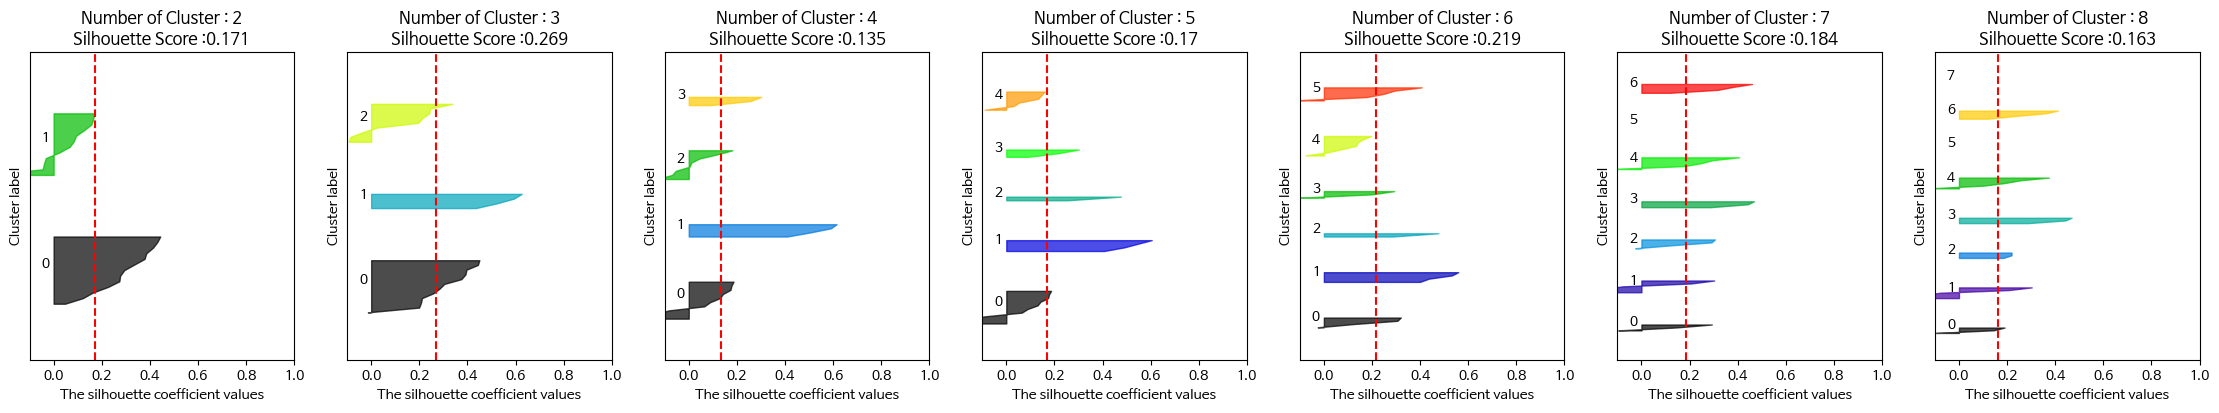

In [389]:
visualize_silhouette2(range(2,9), df_scaled)

In [398]:
# K-means Clustering
kmedoids = KMedoids(n_clusters=3, random_state=0)
Kmedoids_result = kmedoids.fit_predict(dong_scaled)

dong_df['kmedoids'] = Kmedoids_result
dong_df['kmedoids'].value_counts()

2    24
1    20
0    19
Name: kmedoids, dtype: int64

In [399]:
dong_scaler = MinMaxScaler()
dong_cluster = dong_df.copy()
dong_cluster[dong_columns] = dong_scaler.fit_transform(dong_cluster[dong_columns])

In [400]:
dong_cluster.head()

,기초생활수급자비율,노령층비율,장애인비율,차상위비율,complete_linkage,ward_linkage,kmeans,kmedoids
0,0.037724,0.216681,0.000000,0.000000,1,1,0,1
1,0.022513,0.170554,0.045203,0.044056,1,1,0,1
2,0.000000,0.000000,0.069577,0.038624,1,1,0,1
3,0.029510,0.177114,0.079548,0.109234,1,1,0,1
4,0.020992,0.420970,0.061378,0.103199,1,0,0,1


In [401]:
for c in ('complete_linkage', 'ward_linkage', 'kmeans', 'kmedoids'):
  d = dong_cluster.groupby(c, as_index=False)[dong_columns].mean()
  display(d)
  print('')

,complete_linkage,기초생활수급자비율,노령층비율,장애인비율,차상위비율
0,0,0.337009,0.596908,0.270175,0.561617
1,1,0.205807,0.436189,0.183609,0.120419


,ward_linkage,기초생활수급자비율,노령층비율,장애인비율,차상위비율
0,0,0.322863,0.626737,0.251269,0.312613
1,1,0.072839,0.164098,0.118045,0.139758


,kmeans,기초생활수급자비율,노령층비율,장애인비율,차상위비율
0,0,0.075449,0.199575,0.105821,0.106676
1,1,0.361038,0.701142,0.241886,0.207162
2,2,0.264527,0.455748,0.318321,0.662945


,kmedoids,기초생활수급자비율,노령층비율,장애인비율,차상위비율
0,0,0.462956,0.737955,0.236381,0.436934
1,1,0.064527,0.185188,0.089010,0.149095
2,2,0.229300,0.540391,0.292802,0.213614


In [402]:
for c in ('complete_linkage', 'ward_linkage', 'kmeans', 'kmedoids'):
  print(c)
  df = dong_cluster.groupby(c)[dong_columns].mean()
  d = round(df.sum(axis=1)/4 * 100).values
  d = pd.DataFrame(data = {'score':d})
  display(d)
  print('')

complete_linkage


,score
0,44.0
1,24.0



ward_linkage


,score
0,38.0
1,12.0



kmeans


,score
0,12.0
1,38.0
2,43.0



kmedoids


,score
0,47.0
1,12.0
2,32.0


In [415]:
## complete -> cluster 0
## ward -> cluster 0
## kmeans -> cluster 1,2
## kmedois -> cluster 0

dong_df['Complete Linkage'] = [1 if c==0 else 0 for c in dong_df['complete_linkage']]
dong_df['Ward Linkage'] = [1 if c==0 else 0 for c in dong_df['ward_linkage']]
dong_df['K-Means Clustering'] = [1 if c!=0 else 0 for c in dong_df['kmeans']]
dong_df['K-Medoids Clustering'] = [1 if c==0 else 0 for c in dong_df['kmedoids']]

In [404]:
dong_df = pd.concat([dong.loc[dong['시군구명'].isin(select_gu),['행정구역코드', '시군구명', '행정동명']], dong_df], axis=1)

In [416]:
dong_df['거주취약계층'] = dong_df['Complete Linkage'] + dong_df['Ward Linkage'] + dong_df['K-Means Clustering'] + dong_df['K-Medoids Clustering']
dong_df.reset_index(drop=True, inplace=True)
dong_df.head()

,행정구역코드,시군구명,행정동명,기초생활수급자비율,노령층비율,장애인비율,차상위비율,complete_linkage,ward_linkage,kmeans,kmedoids,Complete Linkage,Ward Linkage,K-Means Clustering,K-Medoids Clustering,거주취약계층
0,1101072,종로구,청운효자동,0.000560,0.001272,0.000577,0.000006,1,1,0,1,0,0,0,0,0
1,1101053,종로구,사직동,0.000387,0.001079,0.001094,0.000480,1,1,0,1,0,0,0,0,0
2,1101054,종로구,삼청동,0.000131,0.000364,0.001373,0.000422,1,1,0,1,0,0,0,0,0
3,1101055,종로구,부암동,0.000467,0.001106,0.001487,0.001181,1,1,0,1,0,0,0,0,0
4,1101056,종로구,평창동,0.000370,0.002128,0.001279,0.001116,1,0,0,1,0,1,0,0,1


In [406]:
# 지도 시각화 geo.json 파일로드 및 서울시만 추출
with open('geo.json', 'r') as f:
  data = json.load(f)

feat, d_code = [], {}
for d in data['features']:
  # print((d['properties']['code']))
  # break
  c, n = d['properties']['code'], d['properties']['name']
  if c < '2000000':
    feat.append(d)
    if n in d_code:
      print(n, c, d_code[n])
    else:
      d_code[n] = c

data['features'] = feat

신사동 1123051 1121068


In [417]:
dong_df['행정구역코드'] = dong_df['행정구역코드'].astype(str)
dong_df['행정구역코드'] = [d_code[d] for d in dong_df['행정동명']]
dong_df['행정구역코드'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 63 entries, 0 to 62
Series name: 행정구역코드
Non-Null Count  Dtype 
--------------  ----- 
63 non-null     object
dtypes: object(1)
memory usage: 632.0+ bytes


In [408]:
for i, f in enumerate(data['features']):
  try:
    # print(f['properties']['code'])
    env_r = dong[dong['행정구역코드'] == f['properties']['code']]
    for c in dong_columns:
      data['features'][i]['properties'][c] = str(env_r[c].values[0])
  except:
    try:
      env_r = dong[dong['행정동명'] == f['properties']['name']]
      for c in dong_columns:
        data['features'][i]['properties'][c] = str(env_r[c].values[0])
    except:
      print(f['properties']['code'], f['properties']['name'])

In [409]:
# 지도시각화 함수 - 컬럼, 지도데이터, 색상
def plot_dong(data, df, colname, color, tooltip=True):
  m1 = folium.Map(location=[37.5502, 126.982], tiles='cartodbpositron', zoom_start=11)

  m1.choropleth(
      geo_data=data,
      name = colname,
      data = df,
      columns = ['행정구역코드', colname],
      key_on='properties.code',
      fill_color=color,
      highlight=True,
      fill_opacity=0.7,
      line_opacity=0.5,
      legend_name=colname
  )

  style_function = lambda x: {'fillColor': '#ffffff',
                              'color':'#000000',
                              'fillOpacity': 0.1,
                              'weight': 0.1}

  highlight_function = lambda x: {'fillColor': '#000000',
                                  'color':'#000000',
                                  'fillOpacity': 0.50,
                                  'weight': 0.1}
  if tooltip:
    SuburbName = folium.features.GeoJson(
        data,
        style_function=style_function,
        control=False,
        highlight_function=highlight_function,
        tooltip=folium.features.GeoJsonTooltip(
            fields=['name', 'code', colname],
            aliases=['행정동명','행정구역코드', colname],
            style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;"),
            sticky=True
            )
        )
  else:
    SuburbName = folium.features.GeoJson(
        data,
        style_function=style_function,
        control=False,
        highlight_function=highlight_function,
        tooltip=folium.features.GeoJsonTooltip(
            fields=['name', 'code'],
            aliases=['행정동명','행정구역코드'],
            style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;"),
            sticky=True
            )
      )
  m1.add_child(SuburbName)
  m1.keep_in_front(SuburbName)
  folium.LayerControl().add_to(m1)

  return m1

In [410]:
def cluster_result(cluster_t):
  print(cluster_t)
  print(*dong_df.loc[dong_df[cluster_t]==max(dong_df[cluster_t]), '행정동명'])
  return plot_dong(data, dong_df, cluster_t, 'YlGn', False)

In [418]:
## Complete Linkage
cluster_result('Complete Linkage')

Output hidden; open in https://colab.research.google.com to view.

In [419]:
## Ward Linkage
cluster_result('Ward Linkage')

Output hidden; open in https://colab.research.google.com to view.

In [420]:
## K-Means Clustering
cluster_result('K-Means Clustering')

Output hidden; open in https://colab.research.google.com to view.

In [421]:
## K-Medoids Clustering
cluster_result('K-Medoids Clustering')

Output hidden; open in https://colab.research.google.com to view.

In [422]:
## 주거취약계층
cluster_result('거주취약계층')

Output hidden; open in https://colab.research.google.com to view.

In [423]:
dong_select = dong_df.loc[dong_df['거주취약계층']==4, '행정동명']
print(*dong_select)

미아동 송중동 번1동 번2동 번3동 공릉1동 공릉2동 중계4동 중계2·3동 상계1동 상계3·4동 상계5동


In [424]:
dong[dong['행정동명'].isin(dong_select)]

,행정구역코드,행정동코드,시군구명,행정동명,1인세대비율,기초생활수급자비율,외국인비율,노령층비율,장애인비율,차상위비율,complete_linkage
131,1109070,11305535,강북구,미아동,0.003267,0.003587,0.002023,0.002796,0.001279,0.004186,0
132,1109071,11305545,강북구,송중동,0.003187,0.004050,0.002340,0.003722,0.004815,0.004264,0
135,1109060,11305590,강북구,번1동,0.003075,0.003421,0.001671,0.002240,0.006527,0.009520,2
136,1109061,11305600,강북구,번2동,0.001623,0.004493,0.000564,0.002379,0.003784,0.006249,2
137,1109062,11305606,강북구,번3동,0.001333,0.006624,0.000501,0.002652,0.008545,0.010759,2
160,1111079,11350595,노원구,공릉1동,0.004774,0.006499,0.002105,0.004167,0.002571,0.005600,0
161,1111056,11350600,노원구,공릉2동,0.003289,0.002421,0.003350,0.003478,0.004278,0.004049,0
166,1111064,11350624,노원구,중계4동,0.001435,0.004860,0.000266,0.002391,0.003432,0.005256,2
167,1111078,11350625,노원구,중계2·3동,0.002795,0.011501,0.000804,0.004383,0.000823,0.003173,1
168,1111065,11350630,노원구,상계1동,0.002485,0.004621,0.000772,0.004555,0.001702,0.005412,0


In [425]:
## 스케일링
from sklearn.preprocessing import StandardScaler
d_scaler = MinMaxScaler()
env_c = ['1인세대비율','기초생활수급자비율','외국인비율','노령층비율','장애인비율','차상위비율']

d_scale = env_p.copy()
d_scale[env_c] = d_scaler.fit_transform(d_scale[env_c])
# d_scale[env_c].describe()

In [426]:
d_scale['score'] = (d_scale['1인세대비율'] + d_scale['기초생활수급자비율'] + d_scale['노령층비율'] + d_scale['장애인비율'] + d_scale['차상위비율'])/5*100
d_scale.sort_values(by='score', ascending=False).head(20)

,행정구역코드,행정동코드,시군구명,행정동명,1인세대비율,기초생활수급자비율,외국인비율,노령층비율,장애인비율,차상위비율,score
137,1109062,11305606,강북구,번3동,0.146011,0.455931,0.010140,0.492602,0.711664,1.000000,56.124180
160,1111079,11350595,노원구,공릉1동,0.526751,0.447356,0.055439,0.776424,0.214090,0.520217,49.696765
244,1116073,11500540,강서구,화곡1동,0.858291,0.358742,0.140308,1.000000,0.209449,0.018709,48.903832
135,1109060,11305590,강북구,번1동,0.338731,0.235350,0.043192,0.415434,0.543556,0.884731,48.356043
243,1116054,11500535,강서구,등촌3동,0.392685,1.000000,0.027061,0.789994,0.152499,0.004828,46.800141
178,1112072,11380530,은평구,불광2동,0.388382,0.388518,0.038122,0.690918,0.321451,0.540133,46.588056
167,1111078,11350625,노원구,중계2·3동,0.307819,0.791806,0.018699,0.816725,0.068551,0.294508,45.588171
276,1118052,11545610,금천구,독산1동,0.750552,0.311101,0.249473,0.702853,0.255220,0.226916,44.932840
129,1108085,11290810,성북구,석관동,0.417936,0.330395,0.089413,0.825145,0.469521,0.198552,44.830982
170,1111076,11350665,노원구,상계3·4동,0.263319,0.464507,0.015736,0.693943,0.267032,0.540736,44.590737


In [427]:
d_scale[d_scale['시군구명'].isin(select_gu)].sort_values(by='score', ascending=False).head(20)

,행정구역코드,행정동코드,시군구명,행정동명,1인세대비율,기초생활수급자비율,외국인비율,노령층비율,장애인비율,차상위비율,score
137,1109062,11305606,강북구,번3동,0.146011,0.455931,0.010140,0.492602,0.711664,1.000000,56.124180
160,1111079,11350595,노원구,공릉1동,0.526751,0.447356,0.055439,0.776424,0.214090,0.520217,49.696765
135,1109060,11305590,강북구,번1동,0.338731,0.235350,0.043192,0.415434,0.543556,0.884731,48.356043
167,1111078,11350625,노원구,중계2·3동,0.307819,0.791806,0.018699,0.816725,0.068551,0.294508,45.588171
170,1111076,11350665,노원구,상계3·4동,0.263319,0.464507,0.015736,0.693943,0.267032,0.540736,44.590737
171,1111069,11350670,노원구,상계5동,0.243843,0.332301,0.016592,0.579662,0.139844,0.873868,43.390362
132,1109071,11305545,강북구,송중동,0.351186,0.278704,0.062088,0.692962,0.400970,0.395896,42.394367
168,1111065,11350630,노원구,상계1동,0.273510,0.318009,0.017777,0.849015,0.141742,0.502716,41.699823
138,1109063,11305610,강북구,수유1동,0.290664,0.267270,0.025744,0.509687,0.572664,0.436331,41.532317
139,1109064,11305620,강북구,수유2동,0.223631,0.234159,0.019160,0.545982,1.000000,0.041642,40.908283


In [428]:
d_scale[d_scale['행정동명'].isin(dong_select)].sort_values(by='score', ascending=False)

,행정구역코드,행정동코드,시군구명,행정동명,1인세대비율,기초생활수급자비율,외국인비율,노령층비율,장애인비율,차상위비율,score
137,1109062,11305606,강북구,번3동,0.146011,0.455931,0.010140,0.492602,0.711664,1.000000,56.124180
160,1111079,11350595,노원구,공릉1동,0.526751,0.447356,0.055439,0.776424,0.214090,0.520217,49.696765
135,1109060,11305590,강북구,번1동,0.338731,0.235350,0.043192,0.415434,0.543556,0.884731,48.356043
167,1111078,11350625,노원구,중계2·3동,0.307819,0.791806,0.018699,0.816725,0.068551,0.294508,45.588171
170,1111076,11350665,노원구,상계3·4동,0.263319,0.464507,0.015736,0.693943,0.267032,0.540736,44.590737
171,1111069,11350670,노원구,상계5동,0.243843,0.332301,0.016592,0.579662,0.139844,0.873868,43.390362
132,1109071,11305545,강북구,송중동,0.351186,0.278704,0.062088,0.692962,0.400970,0.395896,42.394367
168,1111065,11350630,노원구,상계1동,0.273510,0.318009,0.017777,0.849015,0.141742,0.502716,41.699823
161,1111056,11350600,노원구,공릉2동,0.362509,0.166508,0.090598,0.647347,0.356254,0.375981,38.171981
136,1109061,11305600,강북구,번2동,0.178112,0.309195,0.011917,0.441429,0.315123,0.580567,36.488538
